In [2]:
import yfinance as yf
import pandas as pd
import os

In [34]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max") 
    sp500.to_csv("sp500.csv")

In [42]:
sp500.index

DatetimeIndex(['1950-01-03', '1950-01-04', '1950-01-05', '1950-01-06',
               '1950-01-09', '1950-01-10', '1950-01-11', '1950-01-12',
               '1950-01-13', '1950-01-16',
               ...
               '2022-09-16', '2022-09-19', '2022-09-20', '2022-09-21',
               '2022-09-22', '2022-09-23', '2022-09-26', '2022-09-27',
               '2022-09-28', '2022-09-29'],
              dtype='datetime64[ns]', name='Date', length=18305, freq=None)

In [35]:
sp500.index = pd.to_datetime(sp500.index)

In [36]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000,0,0
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000,0,0
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000,0,0
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000,0,0
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000,0,0
...,...,...,...,...,...,...,...
2022-09-23,3727.139893,3727.139893,3647.469971,3693.229980,5144270000,0,0
2022-09-26,3682.719971,3715.669922,3644.760010,3655.040039,4886140000,0,0
2022-09-27,3686.439941,3717.530029,3623.290039,3647.290039,4577740000,0,0


<AxesSubplot:xlabel='Date'>

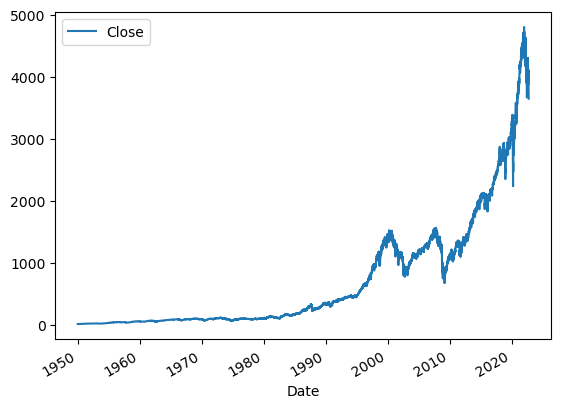

In [6]:
sp500.plot.line(y="Close", use_index=True)

In [7]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [8]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [9]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [10]:
sp500 = sp500.loc["1990-01-01":].copy()

In [11]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2022-09-23,3727.139893,3727.139893,3647.469971,3693.229980,5144270000,3655.040039,0
2022-09-26,3682.719971,3715.669922,3644.760010,3655.040039,4886140000,3647.290039,0
2022-09-27,3686.439941,3717.530029,3623.290039,3647.290039,4577740000,3719.040039,1


In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [13]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.4457831325301205

<AxesSubplot:xlabel='Date'>

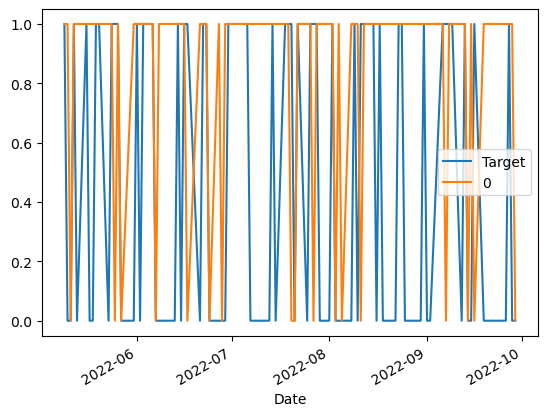

In [14]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [15]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [16]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [17]:
predictions = backtest(sp500, model, predictors)

In [18]:
predictions["Predictions"].value_counts()

0    3340
1    2411
Name: Predictions, dtype: int64

In [20]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5333886354209871

In [21]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.535385
0    0.464615
Name: Target, dtype: float64

In [22]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [23]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [24]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-23,3727.139893,3727.139893,3647.469971,3693.229980,5144270000,3655.040039,0,0.991309,0.0,0.972058,1.0,0.922230,27.0,0.858603,121.0,1.039105,542.0
2022-09-26,3682.719971,3715.669922,3644.760010,3655.040039,4886140000,3647.290039,0,0.994803,0.0,0.974567,0.0,0.913189,27.0,0.850276,121.0,1.028142,542.0
2022-09-27,3686.439941,3717.530029,3623.290039,3647.290039,4577740000,3719.040039,1,0.998939,0.0,0.983443,0.0,0.911929,26.0,0.849036,120.0,1.025743,542.0


In [25]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50,random_state=1)

In [26]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [27]:
predictions = backtest(sp500, model, new_predictors)

In [37]:
predictions["Predictions"].value_counts()

0.0    3941
1.0     810
Name: Predictions, dtype: int64

In [38]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5691358024691358

In [39]:
predictions["Target"].value_counts() / predictions.shape[0]


1    0.54599
0    0.45401
Name: Target, dtype: float64

In [40]:
predictions

,Target,Predictions
Date,,
2003-11-14,0,0.0
2003-11-17,0,1.0
2003-11-18,1,1.0
2003-11-19,0,0.0
2003-11-20,1,1.0
...,...,...
2022-09-23,0,1.0
2022-09-26,0,1.0
2022-09-27,1,1.0
